# Further Feature Engineering and Modeling

This journal represents a humbling attempt to best our own model. Aggressive KMeans clustering initially led us to believe we had a high performing model, but we later realized that it was merely training itself to be specific to LA county.

We will walk you through our thought processess and discuss each model's shortcomings, as well as recommendations depending on the goal of your Yelp app.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans

from xgboost import XGBRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
import pickle
import folium

In [86]:
df= pd.read_csv('../data/03_data_income.csv')
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [87]:
df['zip_code'] = df['zip_code'].astype(str)
df.dtypes

id               object
latitude        float64
longitude       float64
price             int64
review_count    float64
rating          float64
zip_code         object
city             object
alias            object
category         object
med_agi           int64
avg_agi           int64
count             int64
dtype: object

In [88]:
df_pivot = df.pivot_table(index='zip_code').reset_index()

In [7]:
# df_pivot.to_csv('../data/data_zipcode_j.csv')

## Making custom transformers: Adjusted Price

Different types of businesses will have a different distribution of price ranges depending on the product or service they provide. For example, a taco shop with a price rating of '$$' is actually relatively expensive, whereas a sushi restaurant with the same rating is quite common. We hypothesize that a neighborhood with expensive taco shops might be more affluent than a neighborhood with average-priced sushi restaurants; more generally, neighborhoods with disproportionately expensive businessess might be more wealthy than those with just objectively expensive businesses.

In [107]:
print(df[df['category'].str.contains('tacos')]['price'].mean())
print(df[df['category'].str.contains('sushi')]['price'].mean())

1.2374581939799332
2.0346938775510206


We introduce the idea of an adjusted price, which has the goal of scaling a listing's price relative to the overall expensiveness of its parent category. We will calculate the adjusted price by looking at businesses category-by-category and standard scaling the listed price to the mean of that category.

Since we do not want to have any data leakage, we can only apply this transformation on our training data set.

In [144]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://www.slideshare.net/PyData/julie-michelman-pandas-pipelines-and-custom-transformers
# https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.pcv = None
        
    def fit(self, X, y=None):
        self.pcv = CountVectorizer().fit(X['category'])
        print('cv fit')
        return self
            
    def transform(self, X, y=None):     
        
        catpri_cols = ['cat_pri_' + s for s in self.pcv.get_feature_names()]
        print('cv cols')
        C = self.pcv.transform(X['category']).toarray()
        print('cv transform')
        for i in range(len(C)):
            C[i] = C[i] * X['price'].values[i]
        print('cv * price')
        Cdf = pd.DataFrame(C, columns=catpri_cols, index=X.index)
        print('cdf')
        Cdf.replace(0, np.NaN, inplace=True)
        print('cdf replace 0 w nan')
        X = X.join(Cdf)
        print('X join cdf')
        return X

In [90]:
class StandardizerAndCategoryReducer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.sc = None
        
    def fit(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        self.sc = StandardScaler().fit(X[num_cols])
        return self
            
    def transform(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cluster_cols = [col for col in X.columns if 'cluster' in col]
        
        S = self.sc.transform(X[num_cols])
        Sdf = pd.DataFrame(S, columns=num_cols, index=X.index)
        catpri_cols = [col for col in X.columns if 'cat_pri_' in col]
        
        Sdf.loc[:, 'price_adj'] = Sdf.loc[:, catpri_cols].mean(axis=1)
        Sdf.drop(columns=catpri_cols, inplace=True)
        
        X = X.loc[:, cat_cols + cluster_cols].join(Sdf)
        X.drop(columns='category', inplace=True)
        
        return X

In [108]:
X = df.drop(columns=['avg_agi', 'med_agi', 
                     'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


In [109]:
preprocessor = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])
Z_train = preprocessor.fit_transform(X)
Z_train.head(20)

,latitude,longitude,price,review_count,rating,price_adj
0,-0.865918,1.797864,0.898905,2.401713,-0.106237,0.273958
1,-0.860828,1.866601,-0.833936,-0.523979,-0.721385,-0.593050
2,-0.865098,1.866229,0.898905,0.293319,-0.106237,1.440286
3,-0.864164,1.873697,-0.833936,-0.377103,-1.336532,-0.419023
4,-0.728723,1.624631,0.898905,-0.028862,0.508910,0.364028
5,-0.871440,1.858230,0.898905,-0.388947,0.508910,1.608113
6,-0.824289,1.600982,-0.833936,-0.400792,-0.721385,-0.414354
7,-0.742374,1.737415,0.898905,0.025624,0.508910,1.172865
8,-0.730867,1.710399,-0.833936,-0.542931,-2.566826,-0.340126
9,-0.860725,1.790306,0.898905,2.039259,-0.106237,0.364028


## Transfer learning: KMeans

In [94]:
X = df.drop(columns=['avg_agi', 'med_agi', 
                     'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


In [95]:
def inertia_silhouetter(df, features, somelist):
    
    scores = []

    for k in somelist:
    
        cluster_data = df[features]

        # instantiate KMeans
        km = KMeans(n_clusters=k)
        km.fit(cluster_data)

        inertia = km.inertia_
        sil = silhouette_score(location_data, km.labels_)
        scores.append((k, inertia, sil))
        
    scores_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette'])
        
    fig, axes = plt.subplots(1, 2, figsize=(13, 8))
    axes[0].plot(scores_df.k, scores_df.inertia)
    axes[0].set_title('inertia vs. k')
    axes[1].plot(scores_df.k, scores_df.silhouette);
    axes[1].set_title('silhouette score vs. k')
    
    return scores_df

,k,inertia,silhouette
0,2,1067.743127,0.394059
1,12,142.692225,0.429196
2,22,70.407543,0.421550
3,32,47.364154,0.413496
4,42,35.249139,0.413371
5,52,27.718518,0.416892
6,62,22.060894,0.428224
7,72,18.570411,0.424308
8,82,15.457919,0.443793
9,92,13.703331,0.439017


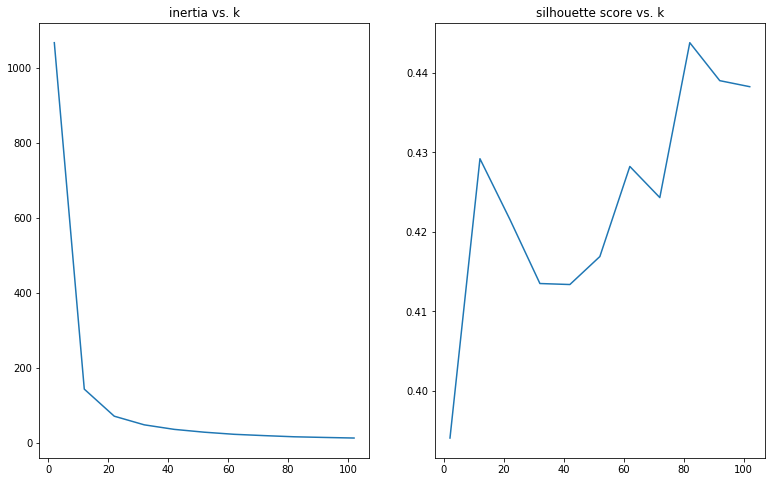

In [72]:
inertia_silhouetter(X, ['latitude', 'longitude'], range(2, 103, 10))

,k,inertia,silhouette
0,8,232.272010,0.405710
1,9,204.939568,0.420037
2,10,180.289107,0.437783
3,11,159.250030,0.431647
4,12,142.498311,0.431963
5,13,129.104179,0.407683
6,14,118.730938,0.425332


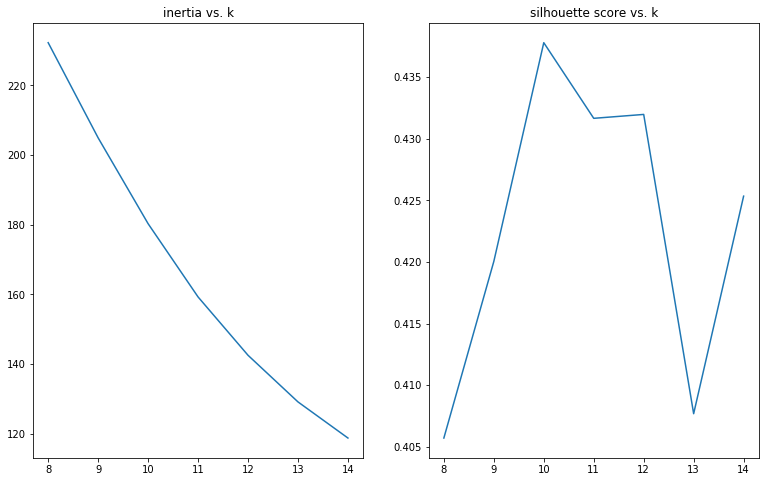

In [70]:
inertia_silhouetter(X, ['latitude', 'longitude'], range(8, 15, 1))

We will use a _k_ of 10.

## Coarse model selection

In [97]:
estimator_dict = {
    'lr': LinearRegression(),
    'knn': KNeighborsRegressor(),
    'bag': BaggingRegressor(),
    'cart': DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'ada': AdaBoostRegressor(),
    'svr': SVR(),
    'xgb': XGBRegressor()
}

In [114]:
X = df.drop(columns=['avg_agi', 'med_agi', 
                     'count', 'city', 'id', 'alias', 'zip_code',
                     'latitude', 'longitude'])
y = df['avg_agi']
X.head()

,price,review_count,rating,category
0,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,1,22.0,3.0,['sandwiches']
2,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,2,231.0,4.0,['italian']


In [121]:
y = df['avg_agi']

estimators = ['lr', 'knn', 'bag', 'cart', 'rf', 'ada', 'svr', 'xgb']

# we will try to cluster the data based on geocoordinates
cluster_data = df[["latitude", "longitude"]]

# this was taken from the silhouette score
km = KMeans(n_clusters=10, random_state = 42)
km.fit(cluster_data)

# this is so we can call the onehot columns 'cluster_xx'
cluster_df = pd.DataFrame(km.labels_.reshape(-1, 1), columns=['cluster'])

oh = OneHotEncoder(categories='auto', sparse=False)
oh.fit(cluster_df)
dummy_cols = oh.get_feature_names(['cluster'])

# create the cluster dummy matrix to concatenate with the original features
dummy_matrix = pd.DataFrame(
    oh.transform(km.labels_.reshape(-1, 1)),
    columns = dummy_cols,
    index = X.index)

X_dummy = pd.concat([X,dummy_matrix], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.33)

# custom pipeline for adjusted price
prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

In [122]:
# loop through each estimator
for estimator in estimators:

    pipe = Pipeline([
        ('prep', prep),
        (estimator, estimator_dict[estimator])
    ])

    pipe.fit(X_train, y_train)
    
    print(estimator)
    print(pipe.score(X_train, y_train))
    print(pipe.score(X_test, y_test))
    print()

lr
0.2819749656894984
0.2891596129112597

knn
0.4488774483156829
0.20483105371767682

bag
0.8474910037952382
0.18507568456534063

cart
0.9938869921642322
-0.3474579919802514

rf
0.8493291027494249
0.18367827962481295

ada
0.030740620083166137
0.047399690262929776



/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


svr
-0.05352503270866604
-0.05856842260281425



/Users/Jelly/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb
0.32925472018608093
0.31676913272584384



In [123]:
y = df['med_agi']

X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.33)

# loop through each estimator
for estimator in estimators:

    pipe = Pipeline([
        ('prep', prep),
        (estimator, estimator_dict[estimator])
    ])

    pipe.fit(X_train, y_train)
    
    print(estimator)
    print(pipe.score(X_train, y_train))
    print(pipe.score(X_test, y_test))
    print()

lr
0.29625940232579717
0.31622218555420956

knn
0.46461762889192365
0.2254974358935108

bag
0.8543861517550183
0.19822271279506412

cart
0.9931941631172392
-0.3259959287110987

rf
0.852761991353548
0.21921475185452524

ada
0.061987826951699465
0.07979101016194068



/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


svr
-0.002293654523634725
-0.004475268027521517



/Users/Jelly/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:30:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb
0.3366242648335461
0.3421459380777879



We will stick with using median income as our target variable.  

`XGBRegressor()` seems the most balanced but is objectively not very good. We will attempt to shift the bias/variance from the higher-performing decision tree models, `BaggingRegressor()` and `RandomForestRegressor()`.

In [124]:
score_df = pd.DataFrame(columns=['params', 
                                 'rmse_train', 
                                 'rmse_test', 
                                 'train', 
                                 'test'])

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.33)

In [146]:
X_train.head()

,price,review_count,rating,category,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
10872,2,278.0,3.5,"['cajun', 'thai', 'seafood']",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7592,1,4.0,4.5,['lounges'],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2448,1,108.0,4.0,['coffee'],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9033,1,27.0,4.0,['burgers'],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14560,2,152.0,4.0,['cajun'],1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
X_train.dtypes

price             int64
review_count    float64
rating          float64
category         object
cluster_0       float64
cluster_1       float64
cluster_2       float64
cluster_3       float64
cluster_4       float64
cluster_5       float64
cluster_6       float64
cluster_7       float64
cluster_8       float64
cluster_9       float64
dtype: object

In [153]:
y_train.head()

10872    47981
7592     74279
2448     90399
9033     39498
14560    74965
Name: med_agi, dtype: int64

In [159]:
Z_train = prep.fit_transform(X_train, y_train)
Z_test = prep.transform(X_test)

In [137]:
Z_train.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,price,review_count,rating,price_adj
10872,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888695,0.084782,-0.103699,0.431800
7592,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.836753,-0.579782,1.129366,-1.771436
2448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.836753,-0.327539,0.512833,-0.560244
9033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.836753,-0.523997,0.512833,-0.594259
14560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888695,-0.220820,0.512833,0.230940


In [138]:
np.isnan(Z_train).sum()

cluster_0       0
cluster_1       0
cluster_2       0
cluster_3       0
cluster_4       0
cluster_5       0
cluster_6       0
cluster_7       0
cluster_8       0
cluster_9       0
price           0
review_count    0
rating          0
price_adj       0
dtype: int64

In [143]:
np.isinf(Z_train).sum()

cluster_0       0
cluster_1       0
cluster_2       0
cluster_3       0
cluster_4       0
cluster_5       0
cluster_6       0
cluster_7       0
cluster_8       0
cluster_9       0
price           0
review_count    0
rating          0
price_adj       0
dtype: int64

In [154]:
rf = RandomForestRegressor()
rf.fit(Z_train, y_train)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [160]:
rf.score(Z_test, y_test)

0.20598389755233484

In [162]:
pipe_params = {
    'rf__n_estimators': [10, 100]
}

pipe = Pipeline([
    ('prep', prep),
    ('rf', RandomForestRegressor())
])
    
grid = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv=2,
    verbose=1,
    n_jobs = 4
)

grid.fit(X_train, y_train)

predictions = grid.predict(X_test)

mse_train = mean_squared_error(y_true = y_train,
                              y_pred = model.predict(X_train))
mse_test = mean_squared_error(y_true = y_test,
                              y_pred = model.predict(X_test))
rmse_train = mse_train ** 0.5
rmse_test = mse_test ** 0.5

scores = {}

scores['params'] = grid.best_params_
scores['rmse_train'] = rmse_train
scores['rmse_test'] = rmse_test
scores['train'] = grid.score(X_train, y_train)
scores['test'] = grid.score(X_test, y_test)

score_df = score_df.append(scores, ignore_index=True)
score_df

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.9s remaining:    5.9s


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
def pipeliner(estimator, k=10, ):
    
    # these dictionaries will allow us to pass string arguments in order to instantiate different objects
    trans_dict = {
        'cvect': CountVectorizer(),
        'tvect': TfidfVectorizer()
    }
    
    est_dict = {
        'mnb': MultinomialNB(),
        'logreg': LogisticRegression(solver='saga'),
        'rand': RandomForestClassifier(n_estimators=10),
        'extra': ExtraTreesClassifier(n_estimators=10)
    }
    
    # this is the actual pipeline object
    pipe = Pipeline([
        (transformer, eval(f'trans_dict["{transformer}"]')),
        ('dense', DenseTransformer()),
        (estimator, eval(f'est_dict["{estimator}"]'))
    ])
    
    return pipe

In [40]:
scores = defaultdict(list)

def transfer_tune(X, y, k):
    
    # get location data from un-pivoted dataframe
    location_data = X[["latitude", "longitude"]]
    
    # instantiate KMeans
    km = KMeans(n_clusters=k)
    
    # fit
    km.fit(location_data)
    
    inertia = km.inertia_
    sil = silhouette_score(location_data, km.labels_)
    
    # insert 'cluster' column with predicted cluster based on k
    X.loc[:, 'cluster'] = km.predict(location_data)
    
    # create dummy columns for cluster
    X_dummy = pd.get_dummies(columns=['cluster'], data=X)
    
    X_dummy.drop(columns=["latitude", "longitude"], inplace=True)
    
    # train-test split on new dummy dataframe
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=111, test_size=0.3
    )
    
    prep = Pipeline([
        ('catpri', CategoryPricer()),
        ('sacr', StandardizerAndCategoryReducer())
    ])
    
    Z_train = prep.fit_transform(X_train)
    Z_test = prep.transform(X_test)
    
    model = LinearRegression()
    model.fit(Z_train, y_train)
    r2 = model.score(Z_test, y_test)
    print(r2)
    # print score vs. k
    return inertia, sil, r2

In [41]:
def transfer_tune_iterator(X, y, somelist):
    
    k_dict = defaultdict(list)
    
    for k in somelist:
        k_dict[k] = transfer_tune(X, y, k)
        
    k_df = pd.DataFrame(k_dict)
    
    return k_df

In [45]:
k_df = transfer_tune_iterator(X, y, range(2, 203, 20))
k_df = k_df.T.rename(columns={0: 'i', 1: 's', 2: 'r2'})

0.2691859914910215
0.31355618944724606
0.32774203963905457
0.35766191887673415
0.3468018295770292
0.36479997556650967
0.36086732975668057
0.3996988450011499
0.42167982777381396
0.40900124605119137
0.41668150370643775
0.45952220706231384


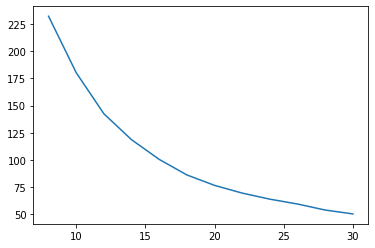

In [60]:
plt.plot(k_df['i'])

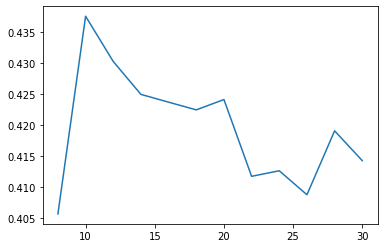

In [48]:
plt.plot(k_df['s'])

In [57]:
df.corr()

,latitude,longitude,price,review_count,rating,med_agi,avg_agi,count
latitude,1.000000,-0.218405,0.012324,-0.013928,-0.003688,-0.010076,-0.001085,-0.092896
longitude,-0.218405,1.000000,-0.141744,-0.055043,-0.048951,-0.162352,-0.271891,-0.045835
price,0.012324,-0.141744,1.000000,0.292298,0.208114,0.182626,0.237329,0.103833
review_count,-0.013928,-0.055043,0.292298,1.000000,0.166327,0.080533,0.110508,0.119049
rating,-0.003688,-0.048951,0.208114,0.166327,1.000000,0.030914,0.067282,0.026384
med_agi,-0.010076,-0.162352,0.182626,0.080533,0.030914,1.000000,0.940798,-0.206464
avg_agi,-0.001085,-0.271891,0.237329,0.110508,0.067282,0.940798,1.000000,-0.143934
count,-0.092896,-0.045835,0.103833,0.119049,0.026384,-0.206464,-0.143934,1.000000


In [58]:
prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

Z_train = prep.fit_transform(X_train)

In [59]:
Z_train

,price,review_count,rating,price_adj
11130,-0.834990,-0.579423,-3.186599,-0.960900
22783,-0.834990,-0.364631,-0.724279,-0.602790
25724,0.899315,-0.192797,1.122461,0.897473
1210,0.899315,-0.381337,1.122461,0.875899
13717,0.899315,0.079273,1.122461,0.737111
...,...,...,...,...
7443,-0.834990,0.189055,1.122461,-0.555462
4182,0.899315,-0.207117,0.506881,0.434370
4820,0.899315,-0.488733,0.506881,1.579880
10196,-0.834990,-0.505439,-1.339859,-0.459670


## just going to see if i can make anything right now

In [26]:
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [27]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code', 'longitude', 'latitude'])
y = df['med_agi']
X.head()

,price,review_count,rating,category
0,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,1,22.0,3.0,['sandwiches']
2,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,2,231.0,4.0,['italian']


## with price_adj, bagging

In [77]:
grid_params = {
    'bagger__n_estimators': [120,140,160],
    }


In [82]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.4
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

pipe = Pipeline([
    ('prep', prep),
    ('bagger', BaggingRegressor())
])

# grid = GridSearchCV(pipe,
#                     param_grid=grid_params,
#                     cv=5,
#                     verbose=1)

pipe.fit(X_train, y_train)
score = pipe.score(X_test)
# score = grid.best_score_

print (score)

<function Pipeline.score at 0x1a33620e18>


In [83]:
pipe.score(X_test, y_test)

0.9354680046585758

In [84]:
y_pred_bag = pipe.predict(X_test)
residuals_bag = y_test - y_pred_bag

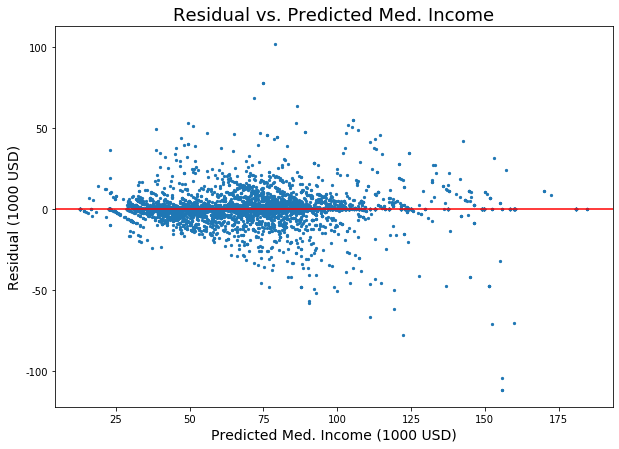

In [85]:
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_bag, residuals_bag, s=5)
plt.axhline(0, color='r')
plt.title('Residual vs. Predicted Med. Income',size = 18)
plt.ylabel("Residual (1000 USD)", fontsize = 14)
plt.xlabel("Predicted Med. Income (1000 USD)", fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x/1000), ',')))
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y/1000), ',')))
plt.show()

## with price_adj, ADAboost

In [86]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


latitude        0
longitude       0
price           0
review_count    0
rating          0
category        0
cluster         0
dtype: int64

In [90]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

pipe = Pipeline(steps=[
    ('prep', prep),
    ('rf', RandomForestRegressor())
])

# grid = GridSearchCV(pipe,
#                     param_grid=grid_params,
#                     cv=5,
#                     verbose=1)

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
# score = grid.best_score_

print (score)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9403246454434404


## with price_adj

In [72]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


In [ ]:
X['price', 'review_count', 'rating', 'category']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X[['price', 'review_count', 'rating', 'category']].copy(),
    y.copy(), random_state=42, test_size=0.3
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

Z_train = prep.fit_transform(X_train)
Z_test = prep.transform(X_test)

lr = LinearRegression()
lr.fit(Z_train, y_train)
r2 = lr.score(Z_test, y_test)
print (r2)

0.03790874504228936


In [71]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

Z_train = prep.fit_transform(X_train)
Z_test = prep.transform(X_test)

lr = LinearRegression()
lr.fit(Z_train, y_train)
r2 = lr.score(Z_test, y_test)
print (r2)

0.8114838329043217


## without price-adj

In [35]:
X1 = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code', 'category'])
y = df['med_agi']
X1.head()

,latitude,longitude,price,review_count,rating
0,33.911154,-117.881259,2,1257.0,3.5
1,33.911959,-117.867374,1,22.0,3.0
2,33.911283,-117.867449,2,367.0,3.5
3,33.911431,-117.865941,1,84.0,2.5
4,33.932860,-117.916253,2,231.0,4.0


In [70]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X1.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X1)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

lr = LinearRegression()
lr.fit(X_train, y_train)
r2 = lr.score(X_test, y_test)
print (r2)

0.8115538253044035


In [38]:
lr.coef_

array([ 4.44852614e+04, -1.03403188e+05,  1.14929374e+03,  2.06255848e-02,
       -9.53445379e+01, -6.33667779e+03, -6.42351063e+03,  3.69774779e+04,
        6.51687135e+04, -1.08790357e+04, -5.13034181e+04, -2.12215318e+04,
       -4.29201192e+04,  1.36027720e+04, -3.72277364e+03, -1.75272058e+03,
       -1.44130888e+04, -1.94787090e+04, -1.00265555e+04, -5.30803274e+04,
       -1.92542314e+04,  3.79311732e+04,  4.16897150e+04,  1.24566348e+04,
        4.52485035e+04, -4.32340108e+04, -1.40372118e+04,  3.60288575e+04,
        1.80654425e+04, -4.20777857e+04, -3.82244010e+04,  3.83808251e+04,
       -1.31303794e+05, -3.84864101e+04, -1.46141329e+03, -1.53983794e+04,
       -1.88729929e+04, -2.75434350e+04, -3.32062536e+04,  8.41806708e+02,
        2.05543891e+04,  7.42842318e+03,  3.63818400e+04,  1.14832235e+04,
        4.15714920e+04, -7.52516492e+03,  3.47723555e+04, -9.23068090e+03,
        2.03356167e+04, -3.56242798e+04,  8.29697498e+02,  2.65531285e+04,
       -1.83286409e+04, -

In [123]:
pd.set_option('display.max_rows', 500)

In [163]:
list(Z_train.columns)

['cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cluster_44',
 'cluster_45',
 'cluster_46',
 'cluster_47',
 'cluster_48',
 'cluster_49',
 'cluster_50',
 'cluster_51',
 'cluster_52',
 'cluster_53',
 'cluster_54',
 'cluster_55',
 'cluster_56',
 'cluster_57',
 'cluster_58',
 'cluster_59',
 'cluster_60',
 'cluster_61',
 'cluster_62',
 'cluster_63',
 'cluster_64',
 'cluster_65',
 'cluster_66',
 'clu

In [69]:
coef_dict = dict(zip(Z_train.columns, lr.coef_))
coef_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coef'])
coef_df.sort_values(by='coef', ascending=False)

,feature,coef
3,price,4729.443837
4,review_count,728.994039
0,cluster,-16.855430
5,rating,-323.233277
6,price_adj,-936.956755
1,latitude,-1007.834407
2,longitude,-3617.984978


In [42]:
y_pred = lr.predict(X_test)

In [43]:
residuals = y_test - y_pred

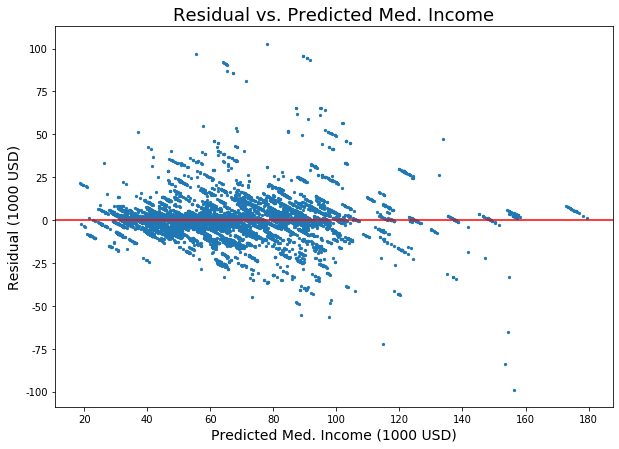

In [66]:
plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, s=5)
plt.axhline(0, color='r')
plt.title('Residual vs. Predicted Med. Income',size = 18)
plt.ylabel("Residual (1000 USD)", fontsize = 14)
plt.xlabel("Predicted Med. Income (1000 USD)", fontsize = 14)
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x/1000), ',')))
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y/1000), ',')))
plt.show()

In [175]:
pickle.dump(lr, open('../flask_app_complete/model.p', 'wb'))

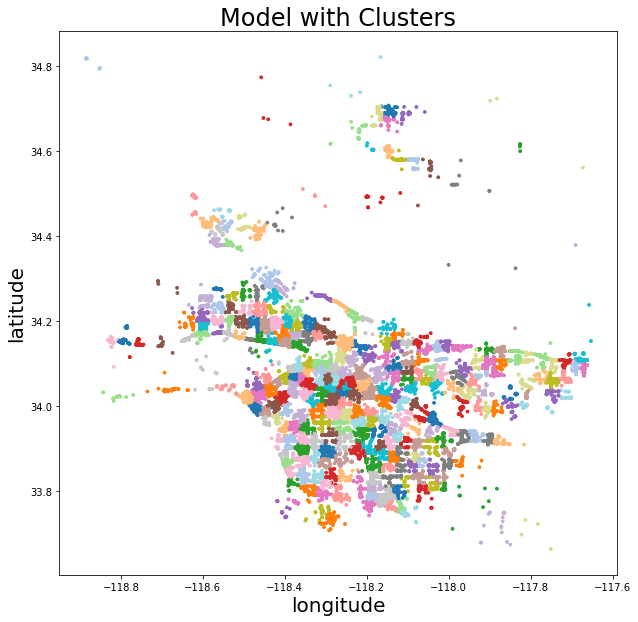

In [164]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)

plt.figure(figsize=(10, 10))
plt.scatter(df.longitude, df.latitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("longitude", fontsize = 20)
plt.ylabel("latitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [166]:
import json

In [167]:
county_bounds = json.loads(open('../Assets/la_county_coordinates.json').read())

la_map = folium.Map(location=[34.3390, -118.2359], zoom_start=10)
folium.GeoJson(county_bounds).add_to(la_map)

la_map.save('../Assets/la_map.html')

In [131]:
Z_cluster = pd.concat([Z_train,Z_test],axis = 0, sort = False)
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [132]:
Z_cluster.sort_index()
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [133]:
Z_cluster = pd.concat([df['zip_code'], Z_cluster.sort_index()], axis=1)

In [134]:
Z_cluster['zip_code'] = Z_cluster['zip_code'].astype(int)

In [135]:
Z_cluster = Z_cluster.astype(float)

In [136]:
Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

array([[0.        , 0.        , 0.        , 0.        , 0.8427673 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.00314465, 0.        ,
        0.        , 0.03144654, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [162]:
len(list(Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012]))

304

In [164]:
len(list(Z_train.columns))

304

In [138]:
bleh = Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

In [165]:
test_model.predict(bleh)

array([98382.47688809])

In [143]:
Z_cluster['zip_code'] = Z_cluster['zip_code'].astype(int)
Z_cluster = Z_cluster.pivot_table(index='zip_code')

In [144]:
# Z_cluster.to_csv('../data/Z_cluster.csv', index=True)

In [45]:
lr.coef_

array([-1.45139458e+04,  9.88163569e+03,  1.44374270e+04,  2.49872908e+04,
        3.33403159e+04, -3.13005142e+04, -2.08267563e+04, -4.08333569e+04,
       -9.77879382e+03,  1.88881475e+04,  5.39097690e+02,  3.20916880e+03,
        4.33672150e+04, -2.11042900e+04, -2.17140656e+04,  2.94385017e+04,
       -1.59584415e+04,  2.40872327e+04,  1.56050358e+04,  9.46470362e+03,
       -1.08032551e+03, -3.01484306e+04,  5.45363816e+03,  2.85212953e+04,
       -9.16359178e+03, -2.82177699e+04,  1.33230642e+04, -3.14608665e+04,
       -2.99148309e+04,  1.29395464e+04,  3.25676579e+04, -2.80881577e+04,
       -3.10983550e+04, -9.68894335e+03, -1.64649616e+04,  2.08069697e+04,
        1.92070365e+03,  1.30221355e+03, -2.61395232e+03,  6.73376915e+03,
        1.36410337e+04, -3.49471165e+03, -1.71186884e+04,  6.64030932e+04,
       -2.89454173e+04,  1.23453369e+04, -1.98429257e+04,  7.45636200e+03,
       -3.75951529e+04,  6.48296559e+03,  7.72206771e+03, -4.33635424e+03,
       -7.01959960e+03,  

In [46]:
df.pivot_table(index='zip_code')[df.pivot_table(index='zip_code').index == '90012']

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count
zip_code,,,,,,,,
90012,61644,318,34.056503,-118.241029,38786,1.578616,3.746855,442.0


In [174]:
test_model = pickle.load(open('../flask_app_complete/model.p','rb'))

In [159]:
test_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [166]:
y_pred_2 = test_model.predict(Z_test)

In [167]:
residuals_2 = y_test - y_pred_2

Text(0.5, 1.0, 'Residual Mean')

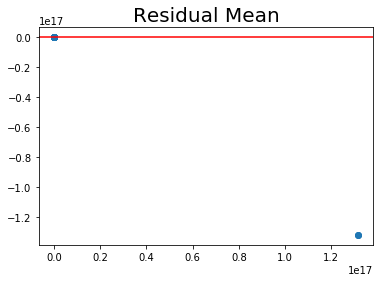

In [168]:
plt.scatter(y_pred_2, residuals_2)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)

In [ ]:
Z_cluster.drop()

In [ ]:
# https://stackoverflow.com/questions/49735683/
df_2 = df_2.groupby('zip_code').filter(lambda x : len(x) > 1)

In [ ]:
train, test = category_pricer(df_2, state=111)

In [ ]:
train['zip_code'].dtype

In [ ]:
drop_columns = ['id', 'city', 'alias', 'med_agi', 'avg_agi', 'count']

X_train = train.drop(columns=drop_columns)
y_train = train['med_agi']

In [ ]:
df_pivot = df_2.pivot_table(index=['zip_code'])
df_pivot['price*review_count'] = df_pivot['price']*df_pivot['review_count']
df_pivot

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
train_pivot = train.pivot_table(index = ['zip_code'])
train_pivot['price*review_count'] = train_pivot['price']*df_pivot['review_count']
train_pivot.head()

In [ ]:
lr = LinearRegression()

In [ ]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['avg_agi'])

In [ ]:
lr.fit(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['avg_agi'])

In [ ]:
lr.fit(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['med_agi'])

In [ ]:
lr.fit(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['med_agi'])

In [ ]:
lr.fit(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

In [ ]:
test_pivot = test.pivot_table(index = ['zip_code'])
test_pivot['price*review_count'] = test_pivot['price']*df_pivot['review_count']
test_pivot.head()

## trying different models

In [ ]:
X_train = train_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_train_avg = train_pivot['avg_agi']
y_train_med = train_pivot['med_agi']

X_test = test_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_test_avg = test_pivot['avg_agi']
y_test_med = test_pivot['med_agi']

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_med)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train_med)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train_med)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train_med)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train_med)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train_med)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train_med)

In [ ]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5

    return (rmse_train, rmse_test)

In [ ]:
rmse_score(linear_reg, X_train, X_test, y_train_med, y_test_med)

In [ ]:
print(linear_reg.score(X_train, y_train_med))
print(linear_reg.score(X_test, y_test_med))

## clustering

In [ ]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude

In [ ]:
transfer_tune_iterator(X, y, range(20, 50, 1))

## median agi

In [ ]:
X_train = train_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_train = df_dummy['med_agi']

In [ ]:
X_test = test_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_test = df_dummy['med_agi']

In [ ]:
def pipeliner(transformer, estimator):
    
    # these dictionaries will allow us to pass string arguments in order to instantiate different objects
    trans_dict = {
        'cvect': CountVectorizer(),
        'tvect': TfidfVectorizer()
    }
    
    est_dict = {
        'mnb': MultinomialNB(),
        'logreg': LogisticRegression(solver='saga'),
        'rand': RandomForestClassifier(n_estimators=10),
        'extra': ExtraTreesClassifier(n_estimators=10)
    }
    
    # this is the actual pipeline object
    pipe = Pipeline([
        (transformer, eval(f'trans_dict["{transformer}"]')),
        ('dense', DenseTransformer()),
        (estimator, eval(f'est_dict["{estimator}"]'))
    ])
    
    return pipe

In [ ]:
def fit_grid_and_track(pipe, split, feature, params, twox, score_df):
    
    t = time.time()
    
    x_train, x_test, y_train, y_test = split
    
    # this condition allows us to calculate top features for the 0 class
    if not twox:
        y_train = 1 - y_train
        y_test = 1 - y_test
    
    # instantiate gridsearch.
    grid = GridSearchCV(pipe, params, cv=5, n_jobs=4)
    grid.fit(x_train[feature], y_train)
    
    best = grid.best_estimator_
    bestparams = grid.best_params_
    train_score = best.score(x_train[feature], y_train)
    test_score = best.score(x_test[feature], y_test)
    
    t = time.time() - t
    
    # only print out stats for the 1 class so we can see what's going on
    if twox:
        
        results = {}
        
        # store each results dictionary into our score DataFrame
        pipe_name = '-'.join([step for step in best.named_steps if step != 'dense'])
        results['pipeline'] = pipe_name
        results['feature'] = feature
        results['params'] = bestparams
        results['test'] = test_score
        results['overfit'] = train_score - test_score
        
        score_df = score_df.append(results, ignore_index=True)
        print(f'{pipe_name}: {feature}  -- {t}')
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print('--------------------------')
        print()
        
    return (best, score_df)

In [ ]:
# this function puts everything together. 
# still unsure if it's more clear like this or as one gigantic function.
# you can be the judge

def pipe_gridder(transformer, estimator, x, y, feature, params, scores):
    
    split = train_test_split(x, y, stratify=y, random_state=111)
    
    pipe = pipeliner(transformer, estimator)
    
    return fit_grid_and_track(pipe, split, feature, params, 1, scores)[1]

In [119]:
def capstone_deadline():
    from datetime import datetime
    from IPython.display import Image, display, HTML    
    
    due_date = datetime(2019, 12, 3, 23, 59)
    time_left = due_date - datetime.now()
    hours_left = round(time_left.total_seconds()/3600,2)
    deadline = due_date.strftime('%B %-d, %Y - %I:%M %p')
    print(f'You have {hours_left} hours left until {deadline}')
    print("Good Luck!")
    display(Image('https://media.giphy.com/media/F4a3ugD96Xl28/giphy.gif'))

You have 626.82 hours left until December 3, 2019 - 11:59 PM
Good Luck!


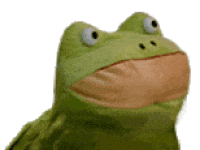

In [120]:
capstone_deadline()

# Trying different models
 - linear regression
 - knn regression
 - decision tree
 - bagging
 - random_forest
 - ada boost
 - support_vector

|model|RMSE Train|RMSE Test|R2 Train|R2 Test|pipeline R2 test|
| --- | --- | --- | --- | ---|---|
|Linear Regression| 0.414|0.44|0.54|0.56|0.43|
|KNN Regression| 0.39|0.51|0.56|0.31|0.33|
|Decision Tree Regression| 8.11e05|0.56|0.99|0.16|0.03|
|Baggin Regression| 0.19|0.46|0.89|0.45|0.54|
|Random Forest Regression| 0.17|0.42|0.92|0.53|0.536|
|Adaboost Regression| 0.29|0.42|0.77|0.53|0.543|
|support vector Regression| 0.17|0.62|0.92|-0.02|-0.02|